# MODEL PERFORMANCE IMPROVEMENT WITH BATCH NORMALIZATION LAYERS

_**Builds a deep neural network of appropriate depth on CIFAR10 dataset and compares the model performance on its convergence, predictions and training time with those of another model with batch normalization (BN) layers added.**_

In [ ]:
# Imports required packages

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Loading and Preprocessing Data

In [ ]:
# Loads CIFAR10 dataset
# Note that first time download may take several minutes to complete

cifar10 = tf.keras.datasets.cifar10.load_data()

In [ ]:
# Considering dataset is organized in tuple, items are referenced as follows
(X_train_full, y_train_full), (X_test, y_test) = cifar10

In [ ]:
# Checks the shape of the training and test dataset
print("Shape of the training dataset:", X_train_full.shape)
print("Shape of the test dataset:", X_test.shape)

Shape of the training dataset: (50000, 32, 32, 3)
Shape of the test dataset: (10000, 32, 32, 3)


In [ ]:
# Splits train dataset further to seperate 5000 instances to be used as validation set

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=5000, random_state=42, stratify=y_train_full)

## Modeling

### Modeling without Batch Normalization Layers

**Creates a densed neural network model with appropriate depth and specific activation and kernel initializer.**

In [ ]:
# Sets the global random seed for operations that rely on a random seed
tf.random.set_seed(42)

# Builds a sequential model
model = tf.keras.Sequential()

# Adds into model a layer that flattens 2D input [e.g. 2D image in this experiment]
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))

# Adds into model 20 dense layers each with 100 outputs and Swish activation function
# As recommended for "Swish", "he" initialization strategy with "normal" distribution was set for weight initialization
for _ in range(20):
    model.add(tf.keras.layers.Dense(100, activation="swish", kernel_initializer="he_normal"))

# Finally, adds into model a 10-output dense layer with "softmax" activation
model.add(tf.keras.layers.Dense(10, activation="softmax"))

/home/pradip/anaconda3/envs/keras3/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Sets the model optimizer and compiles it specific loss function and metric

model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Nadam(learning_rate=5e-5), 
              metrics=["accuracy"])

**Creates callbacks for model checkpoints, early stopping and TensorBoard.**

NOTE: Before continuing, create a root log folder named "logs" in the current working directory to store all log files.

In [ ]:
# Sets the path for the model weights to be stored into. Instead of storing weights across all batches,
# only best weights gets saved.
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("./model_weights/my_cifar10_model.keras", save_best_only=True)

# Sets callback to stop training when model does improve after a certain number of training iterations (e.g. 10 in this experiment)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
# Starts model training process over specified training, validation data and callbacks
model_history = model.fit(X_train, y_train, epochs=50, 
                          validation_data=(X_val, y_val), 
                          callbacks=[early_stopping_callback, model_checkpoint_callback])

Epoch 1/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.1126 - loss: 16.9814 - val_accuracy: 0.1870 - val_loss: 2.2167
Epoch 2/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.2001 - loss: 2.1702 - val_accuracy: 0.2550 - val_loss: 2.0224
Epoch 3/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.2502 - loss: 2.0159 - val_accuracy: 0.2900 - val_loss: 1.9365
Epoch 4/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.2902 - loss: 1.9288 - val_accuracy: 0.2908 - val_loss: 1.9091
Epoch 5/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.3122 - loss: 1.8766 - val_accuracy: 0.3392 - val_loss: 1.8116
Epoch 6/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.3352 - loss: 1.8173 - val_accuracy: 0.3422 - val_loss: 1.8091
Epoch 7/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.3554 - loss: 1.7694 - val_accuracy: 0.3552 - val_loss: 1.7706
Epoch 8/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.3695 - loss: 1.7284 

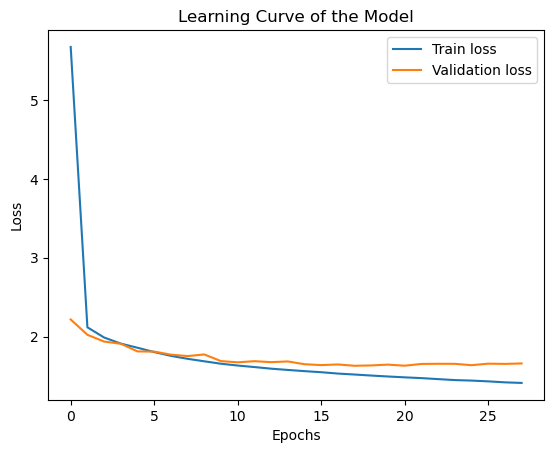

In [ ]:
# Visualizes the training and validation performance over loss function

plt.plot(model_history.history["loss"], label="Train loss")
plt.plot(model_history.history["val_loss"], label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Learning Curve of the Model")
plt.show()

It was observed that there was no improvement in validation performance after epoch 15 and the model exited early from training phase after waiting for 10 epochs.

### Modeling with Batch Normalization Layers

**Now, adds BN layer after every Dense layer (and before the activation function), except for the output layer to check if model performance improves further.**

In [ ]:
# Resets all the keras states
tf.keras.backend.clear_session()

tf.random.set_seed(42)

bn_model = tf.keras.Sequential()

bn_model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))

for _ in range(20):
    bn_model.add(tf.keras.layers.BatchNormalization())
    bn_model.add(tf.keras.layers.Dense(100, activation="swish", kernel_initializer="he_normal"))

bn_model.add(tf.keras.layers.BatchNormalization())    
bn_model.add(tf.keras.layers.Dense(10, activation="softmax"))

bn_model.compile(loss="sparse_categorical_crossentropy", 
                 optimizer=tf.keras.optimizers.Nadam(learning_rate=5e-4), 
                 metrics=["accuracy"])

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("./model_weights/my_cifar10_bn_model.keras", save_best_only=True)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
bn_model_history = bn_model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), 
                                callbacks= [early_stopping_callback, model_checkpoint_callback])

Epoch 1/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 31s 11ms/step - accuracy: 0.1397 - loss: 2.4722 - val_accuracy: 0.2558 - val_loss: 2.0243
Epoch 2/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.2637 - loss: 2.0018 - val_accuracy: 0.3334 - val_loss: 1.8237
Epoch 3/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.3224 - loss: 1.8632 - val_accuracy: 0.3530 - val_loss: 1.7497
Epoch 4/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.3568 - loss: 1.7820 - val_accuracy: 0.4044 - val_loss: 1.6643
Epoch 5/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.3921 - loss: 1.7020 - val_accuracy: 0.4206 - val_loss: 1.6285
Epoch 6/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.4158 - loss: 1.6389 - val_accuracy: 0.4328 - val_loss: 1.6008
Epoch 7/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.4356 - loss: 1.5862 - val_accuracy: 0.4320 - val_loss: 1.6032
Epoch 8/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.4618 -

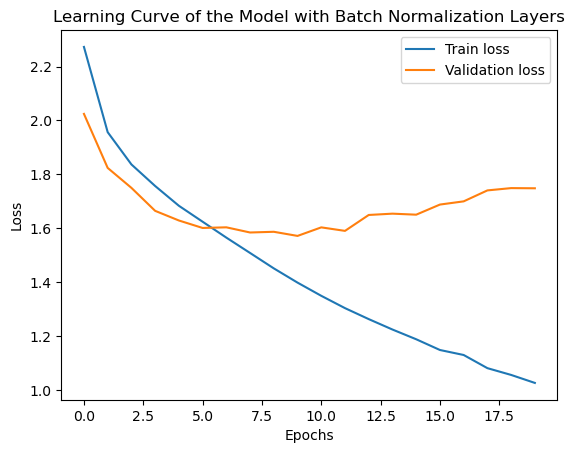

In [ ]:
# Visualizes the training and validation performance over loss function

plt.plot(bn_model_history.history["loss"], label="Train loss")
plt.plot(bn_model_history.history["val_loss"], label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Learning Curve of the Model with Batch Normalization Layers")
plt.show()

### Performance Analysis
Finally compares test performance of both these models over loss function

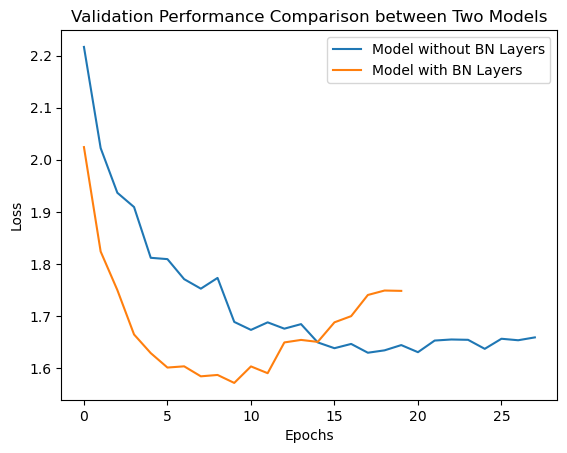

In [ ]:
# Visualized the validation performance comparison between the two models

plt.plot(model_history.history["val_loss"], label="Model without BN Layers")
plt.plot(bn_model_history.history["val_loss"], label="Model with BN Layers")
plt.legend()
plt.title("Validation Performance Comparison between Two Models")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.draw()

In [ ]:
# Prints model's validation peformance
model_val_performance = model.evaluate(X_val, y_val)
bn_model_val_performance = bn_model.evaluate(X_val, y_val)

print("\nValidation Performance [Accuracy]:")
print("{:.3f} [Model without BN layers]".format(model_val_performance[1]))
print("{:.3f} [Model with BN layers]".format(bn_model_val_performance[1]))

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4223 - loss: 1.6260
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4606 - loss: 1.5618

Validation Performance [Accuracy]:
0.425 [Model without BN layers]
0.460 [Model with BN layers]


In [ ]:
# Prints model's test peformance
model_test_performance = model.evaluate(X_test, y_test)
bn_model_test_performance = bn_model.evaluate(X_test, y_test)

print("\nTest Performance [Accuracy]:")
print("{:.3f} [Model without BN layers]".format(model_test_performance[1]))
print("{:.3f} [Model with BN layers]".format(bn_model_test_performance[1]))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4260 - loss: 1.5925
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4568 - loss: 1.5803

Test Performance [Accuracy]:
0.425 [Model without BN layers]
0.454 [Model with BN layers]


**Observations:**

- The model without BN layers took 17 epochs to reach the lowest validation loss, while the model with BN layers achieved the same performance in just 5 epochs and continued to make progress until the 9th epoch. The BN layers stabilized training and allowed us to use a much larger learning rate, so convergence was faster.

- The model with BN layers is also much better, with 46% validation accuracy instead of 42.5% of the other model.

- The same model also performed well in test set by scoring 45.4% accuracy compared to 42.5% accuracy of the other model.

- Although the model with BN layers converged much faster, each step took almost twice (11-12 milliseconds compared to 6-7 milliseconds) compared to that of the other model, because of the extra computations required by the BN layers. But overall the training time (wall time) to reach the best model was less than the time taken by the other model.